In [2]:
import numpy as np
import pandas as pd
import os
from mask_functions import rle2mask
from matplotlib import pyplot as plt
import cv2

%matplotlib inline

In [3]:
# load the two reference submissions 
sub1 = pd.read_csv('submission/8523_0719_unet_512_seed3456_tta.csv.gz')
sub2 = pd.read_csv('submission/8503_0719_unet_512_ensemble5seeds_tta.csv.gz')
sub3 = pd.read_csv('submission/8385_0712_unet_512_seed1234.csv.gz')

In [4]:
sub1.head(5)

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6160.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.582.1517875163...,618672 2 2 8 1012 2 2 8 1000 30 994 30 994 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.6985.151787520...,-1
3,1.2.276.0.7230010.3.1.4.8323329.5865.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6187.151787519...,225594 2 1022 2 1014 12 1012 12 1008 16 1008 1...


In [6]:
sub3.head(5)

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6160.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.582.1517875163...,610480 2 16 12 994 2 16 12 992 8 4 22 990 8 4 ...
2,1.2.276.0.7230010.3.1.4.8323329.6985.151787520...,-1
3,1.2.276.0.7230010.3.1.4.8323329.5865.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6187.151787519...,260364 2 1022 2 13282 6 1018 6 1014 10 1014 10...


In [49]:
# align indices
sub1.columns = ['ImageId', 'enc1']
sub2.columns = ['ImageId', 'enc2']
sub3.columns = ['ImageId', 'enc3']

sub = pd.merge(left=sub1, right=sub2, on='ImageId', how='inner')
sub = pd.merge(left=sub, right=sub3, on='ImageId', how='inner')
print(sub1.shape, sub2.shape, sub3.shape, sub.shape)

(1377, 2) (1377, 2) (1377, 2) (1377, 4)


In [50]:
(sub['enc1']!=sub['enc2']).mean(), (sub['enc1']!=sub['enc3']).mean(), (sub['enc2']!=sub['enc3']).mean()

(0.14960058097313, 0.14451706608569354, 0.13507625272331156)

In [55]:
((sub['enc1']=='-1')&(sub['enc2']=='-1')&(sub['enc3']=='-1')).mean()

0.8424110384894699

In [71]:
# identify the positions where sub1 has empty predictions but sub2 does not
idx1 = np.where((sub['enc1'] == '-1')&(sub['enc2'] != '-1'))[0]
idx2 = np.where((sub['enc1'] == '-1')&(sub['enc3'] != '-1'))[0]
#idx = np.concatenate([idx1, idx2])
idx1, idx2

(array([  90,   98,  130,  137,  164,  213,  216,  268,  348,  368,  383,
         426,  501,  558,  562,  576,  582,  679,  714,  756,  813,  934,
         951, 1012, 1052, 1114, 1125, 1154, 1159, 1367]),
 array([ 130,  213,  268,  346,  383,  558,  568,  713,  714,  756,  764,
         797,  813,  826,  904,  917,  940, 1052, 1114, 1159, 1234, 1299,
        1367]))

In [1]:
# is it really like missing mask?
enc = 'enc3'
i = idx2[11]

mask = rle2mask(sub.loc[i, enc], 1024, 1024)
mask = cv2.resize(mask, (512, 512))
img_id = sub.loc[i, 'ImageId']
img = plt.imread('data/processed/test/%s.png'%img_id)
img = cv2.resize(img, (512, 512))

plt.imshow(img, cmap=plt.cm.bone)
plt.imshow(mask, alpha=0.3, cmap="Reds")

In [2]:
sub.head(5)

In [79]:
# map non-empty sub2,sub3... slots to empty ones in sub1
sub['EncodedPixels'] = sub['enc1']
sub['EncodedPixels'][idx1] = sub['enc2'][idx1]
sub['EncodedPixels'][idx2] = sub['enc3'][idx2]

In [81]:
sub[['ImageId','EncodedPixels']].to_csv('submission/dirty_ensemble.csv.gz', index=False, compression='gzip')

In [ ]:
#dirty ensemble LB=0.8471

## voting on each pixel, [see here](https://www.kaggle.com/giuliasavorgnan/pneumothorax-models-ensemble-average)

In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
import sys
#import skimage.measure
import PIL
from tqdm import tqdm, tqdm_notebook

from mask_functions import rle2mask, mask2rle
from matplotlib import pyplot as plt

%matplotlib inline

## ensemble LB scores:
- ensemble different model architectures helps!!!

In [71]:
# read all submissions into daframes and store them in a list
# use_subs = ['submission/8503_0719_unet_512_ensemble5seeds_tta.csv.gz',
#             'submission/8512_0714_unet_512_seed3456.csv.gz',
#             'submission/8523_0719_unet_512_seed3456_tta.csv.gz'] #LB=0.8545 #min_solutions=2

# use_subs = ['submission/8385_0712_unet_512_seed1234.csv.gz', 
#            'submission/8415_0714_unet_512_seed5678.csv.gz', 
#            'submission/8431_0714_unet_512_seed4567.csv.gz',
#            'submission/8446_0714_unet_512_seed2345.csv.gz',
#            'submission/8523_0719_unet_512_seed3456_tta.csv.gz'
#            ] #LB=0.8493 min_solutions=3

# use_subs = ['submission/8523_0719_unet_512_seed3456_tta.csv.gz', 
#            'submission/8512_0714_unet_512_seed3456.csv.gz', 
#             'submission/8503_0719_unet_512_ensemble5seeds_tta.csv.gz', 
#            'submission/8465_0720_unet_512_seed3456_tta_v2.csv.gz',
#            'submission/8436_0719_multitask_unet_512_seed3456.csv.gz'
#            ] #LB=0.8529 #min_solutions=3

# use_subs = ['submission/8503_0719_unet_512_ensemble5seeds_tta.csv.gz',
#             'submission/8481_0725_deeplabv3plus_512_seed2345_tta_v1.csv.gz',
#             'submission/8523_0719_unet_512_seed3456_tta.csv.gz'] #LB=0.8556 #min_solutions=2

# use_subs = ['submission/8551_0728_deeplabv3plus_768_seed3456_tta_v1.csv.gz',
#             'submission/8538_0728_deeplabv3plus_1024_seed3456_tta_v1.csv.gz',
#             'submission/8523_0719_unet_512_seed3456_tta.csv.gz'] #LB=0.8577 #min_solutions=2

# use_subs = ['submission/8554_0729_deeplabv3plus_768_seed2345_tta_v1.csv.gz', 
#             'submission/8551_0728_deeplabv3plus_768_seed3456_tta_v1.csv.gz',
#             'submission/8523_0719_unet_512_seed3456_tta.csv.gz'] #LB=0.8583 #min_solutions=2

# use_subs = ['submission/8554_0729_deeplabv3plus_768_seed2345_tta_v1.csv.gz', 
#             'submission/8551_0728_deeplabv3plus_768_seed3456_tta_v1.csv.gz',
#             'submission/8538_0728_deeplabv3plus_1024_seed3456_tta_v1.csv.gz',
#             'submission/8523_0719_unet_512_seed3456_tta.csv.gz', 
#             'submission/8512_0714_unet_512_seed3456.csv.gz'] #LB=0.8593 #min_solutions=3

# use_subs = ['submission/8605_0730_deeplabv3plus_768_seed1234_tta_v1.csv.gz', 
#             'submission/8560_0730_deeplabv3plus_768_seed2345_tta_v1_2900_019.csv.gz',
#             'submission/8551_0728_deeplabv3plus_768_seed3456_tta_v1.csv.gz'] #LB=0.8629 #min_solutions=2

# use_subs = ['submission/8605_0730_deeplabv3plus_768_seed1234_tta_v1.csv.gz', 
#             'submission/8568_0731_deeplabv3plus_1024_seed1234_tta_v1_6100_021.csv.gz',
#             'submission/8560_0730_deeplabv3plus_768_seed2345_tta_v1_2900_019.csv.gz', 
#             'submission/8551_0728_deeplabv3plus_768_seed3456_tta_v1.csv.gz', 
#             'submission/8538_0728_deeplabv3plus_1024_seed3456_tta_v1.csv.gz'] #LB=0.8636 #min_solutions=3

# use_subs = ['submission/8605_0730_deeplabv3plus_768_seed1234_tta_v1.csv.gz', 
#             'submission/8568_0731_deeplabv3plus_1024_seed1234_tta_v1_6100_021.csv.gz',
#             'submission/8560_0730_deeplabv3plus_768_seed2345_tta_v1_2900_019.csv.gz', 
#             'submission/8551_0728_deeplabv3plus_768_seed3456_tta_v1.csv.gz', 
#             'submission/8538_0728_deeplabv3plus_1024_seed3456_tta_v1.csv.gz', 
#             'submission/8523_0719_unet_512_seed3456_tta.csv.gz', 
#             'submission/8503_0730_deeplabv3plus_1024_seed2345_tta_v1.csv.gz'] #LB=0.8646, min_solutions=3; LB=0.8626, min_solutions=4

# use_subs = ['submission/8605_0730_deeplabv3plus_768_seed1234_tta_v1.csv.gz', 
#             'submission/8568_0731_deeplabv3plus_1024_seed1234_tta_v1_6100_021.csv.gz',
#             'submission/8560_0730_deeplabv3plus_768_seed2345_tta_v1_2900_019.csv.gz', 
#             'submission/8557_0801_unet_768_seed3456_tta_v1.csv.gz',
#             'submission/8551_0728_deeplabv3plus_768_seed3456_tta_v1.csv.gz', 
#             'submission/8538_0728_deeplabv3plus_1024_seed3456_tta_v1.csv.gz', 
#             'submission/8530_0801_unet_768_seed2345_tta_v1.csv.gz'] #LB=0.8668, min_solutions=3;

# use_subs = ['submission/8605_0730_deeplabv3plus_768_seed1234_tta_v1.csv.gz', 
#             'submission/8568_0731_deeplabv3plus_1024_seed1234_tta_v1_6100_021.csv.gz',
#             'submission/8560_0730_deeplabv3plus_768_seed2345_tta_v1_2900_019.csv.gz', 
#             'submission/8557_0801_unet_768_seed3456_tta_v1.csv.gz',
#             'submission/8551_0728_deeplabv3plus_768_seed3456_tta_v1.csv.gz', 
#             'submission/8538_0728_deeplabv3plus_1024_seed3456_tta_v1.csv.gz', 
#             'submission/8530_0801_unet_768_seed2345_tta_v1.csv.gz', 
#             'submission/8523_0719_unet_512_seed3456_tta.csv.gz', 
#             'submission/8503_0730_deeplabv3plus_1024_seed2345_tta_v1.csv.gz'] #LB=0.8650, min_solutions=4; LB=0.8623, min_solutions=5

# use_subs = ['submission/8605_0730_deeplabv3plus_768_seed1234_tta_v1.csv.gz', 
#             'submission/8592_0802_unet_768_seed1234_tta_v1_2900_018.csv.gz',
#             'submission/8568_0731_deeplabv3plus_1024_seed1234_tta_v1_6100_021.csv.gz',
#             'submission/8560_0730_deeplabv3plus_768_seed2345_tta_v1_2900_019.csv.gz', 
#             'submission/8557_0801_unet_768_seed3456_tta_v1.csv.gz',
#             'submission/8551_0728_deeplabv3plus_768_seed3456_tta_v1.csv.gz', 
#             'submission/8538_0728_deeplabv3plus_1024_seed3456_tta_v1.csv.gz'] #LB=0.8663, min_solutions=3;

# use_subs = ['submission/8614_0806_deeplabv3plus_1024_seed1234_tta_v2_6000_022.csv.gz',
#             'submission/8611_0730_deeplabv3plus_768_seed1234_tta_v1_2900_022.csv.gz',
#             'submission/8592_0802_unet_768_seed1234_tta_v1_2900_018.csv.gz',
#             'submission/8568_0731_deeplabv3plus_1024_seed1234_tta_v1_6100_021.csv.gz',
#             'submission/8560_0730_deeplabv3plus_768_seed2345_tta_v1_2900_019.csv.gz', 
#             'submission/8557_0801_unet_768_seed3456_tta_v1.csv.gz',
#             'submission/8551_0728_deeplabv3plus_768_seed3456_tta_v1.csv.gz'
#            ] #LB=0.8682, min_solutions=3; LB=0.8665, min_solutions=4

# use_subs = ['submission/8614_0806_deeplabv3plus_1024_seed1234_tta_v2_6000_022.csv.gz',
#             'submission/8611_0730_deeplabv3plus_768_seed1234_tta_v1_2900_022.csv.gz',
#             'submission/8603_0808_deeplabv3plus_1024_seed3456_tta_v2_6300_023.csv.gz',
#             'submission/8597_0808_deeplabv3plus_1024_seed2345_tta_v2_5700_018.csv.gz',
#             'submission/8592_0802_unet_768_seed1234_tta_v1_2900_018.csv.gz',
#            ] #LB=0.8670, min_solutions=3

# use_subs = ['submission/8614_0806_deeplabv3plus_1024_seed1234_tta_v2_6000_022.csv.gz',
#             'submission/8611_0730_deeplabv3plus_768_seed1234_tta_v1_2900_022.csv.gz',
#             'submission/8603_0808_deeplabv3plus_1024_seed3456_tta_v2_6300_023.csv.gz',
#             'submission/8597_0808_deeplabv3plus_1024_seed2345_tta_v2_5700_018.csv.gz',
#             'submission/8592_0802_unet_768_seed1234_tta_v1_2900_018.csv.gz',
#             'submission/8560_0730_deeplabv3plus_768_seed2345_tta_v1_2900_019.csv.gz',
#             'submission/8557_0801_unet_768_seed3456_tta_v1.csv.gz'
#            ] #LB=0.8681, min_solutions=3; LB=0.8667, min_solutions=4; ==== LB=0.8639, min_solutions=2 ====


# use_subs = ['submission/8614_0806_deeplabv3plus_1024_seed1234_tta_v2_6000_022.csv.gz',
#             'submission/8611_0730_deeplabv3plus_768_seed1234_tta_v1_2900_022.csv.gz',
#             'submission/8603_0808_deeplabv3plus_1024_seed3456_tta_v2_6300_023.csv.gz',
#             'submission/8597_0808_deeplabv3plus_1024_seed2345_tta_v2_5700_018.csv.gz',
#             'submission/8592_0802_unet_768_seed1234_tta_v1_2900_018.csv.gz',
#             'submission/8568_0731_deeplabv3plus_1024_seed1234_tta_v1_6100_021.csv.gz',
#             'submission/8560_0730_deeplabv3plus_768_seed2345_tta_v1_2900_019.csv.gz', 
#             'submission/8557_0801_unet_768_seed3456_tta_v1.csv.gz',
#             'submission/8551_0728_deeplabv3plus_768_seed3456_tta_v1.csv.gz',
#             'submission/8549_0804_deeplabv3plus_768_seed4567_tta_v1_3100_019.csv.gz',
#             'submission/8543_0805_deeplabv3plus_768_seed5678_tta_v1_3100_022.csv.gz'
#            ] #LB=0.8656, min_solutions=5; LB=0.8662, min_solutions=6

# use_subs = ['submission/8614_0806_deeplabv3plus_1024_seed1234_tta_v2_6000_022.csv.gz',
#             'submission/8611_0730_deeplabv3plus_768_seed1234_tta_v1_2900_022.csv.gz',
#             'submission/8603_0808_deeplabv3plus_1024_seed3456_tta_v2_6300_023.csv.gz',
#             'submission/8601_0811_unet_1024_seed1234_tta_v1_5300_022.csv.gz',
#             'submission/8597_0808_deeplabv3plus_1024_seed2345_tta_v2_5700_018.csv.gz',
#             'submission/8592_0813_unet_1024_seed2345_tta_v1_6000_018.csv.gz',
#             'submission/8592_0802_unet_768_seed1234_tta_v1_2900_018.csv.gz',
#            ] #LB=0.8699, min_solutions=3; LB=0.8668, min_solutions=4

# use_subs = ['submission/8614_0806_deeplabv3plus_1024_seed1234_tta_v2_6000_022.csv.gz',
#             'submission/8611_0730_deeplabv3plus_768_seed1234_tta_v1_2900_022.csv.gz',
#             'submission/8603_0808_deeplabv3plus_1024_seed3456_tta_v2_6300_023.csv.gz',
#             'submission/8601_0811_unet_1024_seed1234_tta_v1_5300_022.csv.gz',
#             'submission/8597_0808_deeplabv3plus_1024_seed2345_tta_v2_5700_018.csv.gz',
#             'submission/8592_0813_unet_1024_seed2345_tta_v1_6000_018.csv.gz',
#             'submission/8592_0802_unet_768_seed1234_tta_v1_2900_018.csv.gz',
#             'submission/8560_0730_deeplabv3plus_768_seed2345_tta_v1_2900_019.csv.gz',
#             'submission/8557_0801_unet_768_seed3456_tta_v1.csv.gz',
#            ] #LB=0.8701, min_solutions=4

# use_subs = ['submission/8632_0815_deeplabv3plus_1024_seed5678_tta_v2_6000_022.csv.gz',
#             'submission/8614_0806_deeplabv3plus_1024_seed1234_tta_v2_6000_022.csv.gz',
#             'submission/8611_0730_deeplabv3plus_768_seed1234_tta_v1_2900_022.csv.gz',
#             'submission/8609_0815_unet_1024_seed3456_tta_v1_6100_018.csv.gz',
#             'submission/8603_0808_deeplabv3plus_1024_seed3456_tta_v2_6300_023.csv.gz',
#             'submission/8601_0811_unet_1024_seed1234_tta_v1_5300_022.csv.gz',
#             'submission/8592_0813_unet_1024_seed2345_tta_v1_6000_018.csv.gz',
#            ] #LB=0.8701, min_solutions=3

use_subs = ['submission/8632_0815_deeplabv3plus_1024_seed5678_tta_v2_6000_022.csv.gz',
            'submission/8614_0806_deeplabv3plus_1024_seed1234_tta_v2_6000_022.csv.gz',
            'submission/8611_0730_deeplabv3plus_768_seed1234_tta_v1_2900_022.csv.gz',
            'submission/8609_0815_unet_1024_seed3456_tta_v1_6100_018.csv.gz',
            'submission/8603_0808_deeplabv3plus_1024_seed3456_tta_v2_6300_023.csv.gz',
            'submission/8601_0811_unet_1024_seed1234_tta_v1_5300_022.csv.gz',
            'submission/8597_0808_deeplabv3plus_1024_seed2345_tta_v2_5700_018.csv.gz',
            'submission/8592_0813_unet_1024_seed2345_tta_v1_6000_018.csv.gz',
            'submission/8592_0802_unet_768_seed1234_tta_v1_2900_018.csv.gz',
           ] #LB=0.8711, min_solutions=4

# use_subs = ['submission/8632_0815_deeplabv3plus_1024_seed5678_tta_v2_6000_022.csv.gz',
#             'submission/8616_0816_deeplabv3plus_1024_seed6789_tta_v2_6000_019.csv.gz',
#             'submission/8614_0806_deeplabv3plus_1024_seed1234_tta_v2_6000_022.csv.gz',
#             'submission/8611_0730_deeplabv3plus_768_seed1234_tta_v1_2900_022.csv.gz',
#             'submission/8609_0815_unet_1024_seed3456_tta_v1_6100_018.csv.gz',
#             'submission/8603_0808_deeplabv3plus_1024_seed3456_tta_v2_6300_023.csv.gz',
#             'submission/8601_0811_unet_1024_seed1234_tta_v1_5300_022.csv.gz',
#             'submission/8597_0808_deeplabv3plus_1024_seed2345_tta_v2_5700_018.csv.gz',
#             'submission/8596_0816_unet_1024_seed4567_tta_v1_6000_019.csv.gz',
#             'submission/8592_0813_unet_1024_seed2345_tta_v1_6000_018.csv.gz',
#             'submission/8592_0802_unet_768_seed1234_tta_v1_2900_018.csv.gz',
#            ] #LB=0.8704, min_solutions=5

# use_subs = ['submission/8632_0815_deeplabv3plus_1024_seed5678_tta_v2_6000_022.csv.gz',
#             'submission/8614_0806_deeplabv3plus_1024_seed1234_tta_v2_6000_022.csv.gz',
#             'submission/8611_0730_deeplabv3plus_768_seed1234_tta_v1_2900_022.csv.gz',
#             'submission/8609_0815_unet_1024_seed3456_tta_v1_6100_018.csv.gz',
#             'submission/8603_0808_deeplabv3plus_1024_seed3456_tta_v2_6300_023.csv.gz',
#             'submission/8601_0811_unet_1024_seed1234_tta_v1_5300_022.csv.gz',
#             'submission/8600_0821_deeplabv3plus_1024_seed8901_tta_v2_6000_021.csv.gz',
#             'submission/8592_0813_unet_1024_seed2345_tta_v1_6000_018.csv.gz',
#             'submission/8592_0802_unet_768_seed1234_tta_v1_2900_018.csv.gz',
#            ] #LB=0.8684, min_solutions=4

use_subs = ['submission/8674_0823_deeplabv3plus_1024_seed9012_tta_v2_6000_018.csv.gz',
            'submission/8632_0815_deeplabv3plus_1024_seed5678_tta_v2_6000_022.csv.gz',
            'submission/8616_0816_deeplabv3plus_1024_seed6789_tta_v2_6000_019.csv.gz',
            'submission/8614_0806_deeplabv3plus_1024_seed1234_tta_v2_6000_022.csv.gz',
            'submission/8611_0730_deeplabv3plus_768_seed1234_tta_v1_2900_022.csv.gz',
            'submission/8609_0815_unet_1024_seed3456_tta_v1_6100_018.csv.gz',
            'submission/8601_0811_unet_1024_seed1234_tta_v1_5300_022.csv.gz',
            'submission/8592_0813_unet_1024_seed2345_tta_v1_6000_018.csv.gz',
            'submission/8592_0802_unet_768_seed1234_tta_v1_2900_018.csv.gz',
           ] #LB=0.8705, min_solutions=4; LB=0.8710, min_solutions=5

# use_subs = ['submission/8674_0823_deeplabv3plus_1024_seed9012_tta_v2_6000_018.csv.gz',
#             'submission/8632_0815_deeplabv3plus_1024_seed5678_tta_v2_6000_022.csv.gz',
#             'submission/8616_0816_deeplabv3plus_1024_seed6789_tta_v2_6000_019.csv.gz',
#             'submission/8614_0806_deeplabv3plus_1024_seed1234_tta_v2_6000_022.csv.gz',
#             'submission/8611_0730_deeplabv3plus_768_seed1234_tta_v1_2900_022.csv.gz',
#             'submission/8609_0815_unet_1024_seed3456_tta_v1_6100_018.csv.gz',
#             'submission/8601_0811_unet_1024_seed1234_tta_v1_5300_022.csv.gz',
#            ] #LB=0.8709, min_solutions=3; LB=0.8695, min_solutions=4

print('use how many subs: ', len(use_subs))
df_sub_list = [pd.read_csv(f) for f in use_subs]
use_subs

use how many subs:  7


['submission/8674_0823_deeplabv3plus_1024_seed9012_tta_v2_6000_018.csv.gz',
 'submission/8632_0815_deeplabv3plus_1024_seed5678_tta_v2_6000_022.csv.gz',
 'submission/8616_0816_deeplabv3plus_1024_seed6789_tta_v2_6000_019.csv.gz',
 'submission/8614_0806_deeplabv3plus_1024_seed1234_tta_v2_6000_022.csv.gz',
 'submission/8611_0730_deeplabv3plus_768_seed1234_tta_v1_2900_022.csv.gz',
 'submission/8609_0815_unet_1024_seed3456_tta_v1_6100_018.csv.gz',
 'submission/8601_0811_unet_1024_seed1234_tta_v1_5300_022.csv.gz']

In [72]:
# create a list of unique image IDs
for _i in range(len(df_sub_list)):
    iid_list = df_sub_list[_i]["ImageId"].unique()
    print(f"{len(iid_list)} unique image IDs.")

1377 unique image IDs.
1377 unique image IDs.
1377 unique image IDs.
1377 unique image IDs.
1377 unique image IDs.
1377 unique image IDs.
1377 unique image IDs.


In [73]:
## Create average prediction mask for each image ##
# set here the threshold for the final mask
# min_solutions is the minimum number of times that a pixel has to be positive in order to be included in the final mask
min_solutions = 4 # if avg_mask>=min_solutions, then predict a pixel=1
assert (min_solutions >= 1 and min_solutions <= len(df_sub_list)), \
    "min_solutions has to be a number between 1 and the number of submission files"
print('min_solutions: ', min_solutions)

min_solutions:  4


In [74]:
%%time

# create empty final dataframe
df_avg_sub = pd.DataFrame(columns=["ImageId", "EncodedPixels"])
df_avg_sub_idx = 0 # counter for the index of the final dataframe

# iterate over image IDs
for idx, iid in enumerate(tqdm_notebook(iid_list)):
    # initialize prediction mask
    avg_mask = np.zeros((1024,1024))
    # iterate over prediction dataframes
    for df_sub in df_sub_list:
        # extract rles for each image ID and submission dataframe
        rles = df_sub.loc[df_sub["ImageId"]==iid, "EncodedPixels"]
        # iterate over rles
        for rle in rles:
            # if rle is not -1, build prediction mask and add to average mask
            if "-1" not in str(rle):
                avg_mask += rle2mask(rle, 1024, 1024) / float(len(df_sub_list))
    # threshold the average mask
    pred_mask = (avg_mask >= (min_solutions / float(len(df_sub_list)))).astype("uint8")
    # transform to rle
    if pred_mask.sum() > 0:
        im = PIL.Image.fromarray((pred_mask*255).astype(np.uint8)).resize((1024,1024))
        im = np.asarray(im)
        rle = mask2rle(im, 1024, 1024)
    else:
        rle = "-1"
    # add a row in the final dataframe
    df_avg_sub.loc[df_avg_sub_idx] = [iid, rle]
    df_avg_sub_idx += 1 # increment index
    #if idx>10:
    #    break


CPU times: user 18min 7s, sys: 1min 8s, total: 19min 15s
Wall time: 2min 17s


In [63]:
df_avg_sub

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6160.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.582.1517875163...,619708 6 1016 9 1013 14 1 1 1005 19 1001 23 99...
2,1.2.276.0.7230010.3.1.4.8323329.6985.151787520...,-1
3,1.2.276.0.7230010.3.1.4.8323329.5865.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6187.151787519...,255245 1 1022 3 1020 5 1018 7 1015 9 1015 8 10...
5,1.2.276.0.7230010.3.1.4.8323329.5939.151787519...,-1
6,1.2.276.0.7230010.3.1.4.8323329.6013.151787519...,-1
7,1.2.276.0.7230010.3.1.4.8323329.6717.151787519...,-1
8,1.2.276.0.7230010.3.1.4.8323329.694.1517875164...,-1
9,1.2.276.0.7230010.3.1.4.8323329.6622.151787519...,-1


In [64]:
df_sub_list[0]

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6160.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.582.1517875163...,619708 6 1016 9 1013 12 1009 16 1004 20 1002 2...
2,1.2.276.0.7230010.3.1.4.8323329.6985.151787520...,-1
3,1.2.276.0.7230010.3.1.4.8323329.5865.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6187.151787519...,250127 5 1016 11 1011 13 1009 16 1007 17 1006 ...
5,1.2.276.0.7230010.3.1.4.8323329.5939.151787519...,-1
6,1.2.276.0.7230010.3.1.4.8323329.6013.151787519...,-1
7,1.2.276.0.7230010.3.1.4.8323329.6717.151787519...,-1
8,1.2.276.0.7230010.3.1.4.8323329.694.1517875164...,619755 4 1017 10 1012 15 1006 22 1000 30 991 3...
9,1.2.276.0.7230010.3.1.4.8323329.6622.151787519...,-1


In [75]:
df_avg_sub.to_csv('submission/dirty_ensemble.csv.gz', index=False, compression='gzip')

In [8]:
i = 247

410


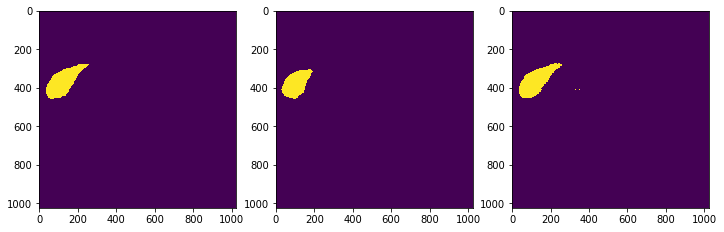

In [182]:
i += 1
print(i)

fig = plt.figure(figsize=(12, 10))

for idx, _df in enumerate(df_sub_list):
    rle = _df.loc[i, 'EncodedPixels']
    if rle=='-1':
        if idx==0:
            break
        else:
            _mask = np.zeros((1024, 1024), dtype=np.float)
    else:
        _mask = rle2mask(rle, 1024, 1024)
    ax = fig.add_subplot(1, len(df_sub_list), idx+1)
    plt.imshow(_mask)
#print('Done')

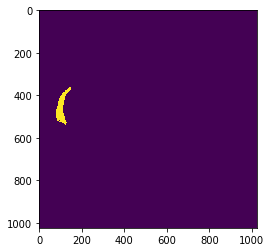

In [155]:
##the ensemble:
rle = df_avg_sub.loc[i, 'EncodedPixels']
if rle=='-1':
    print('Empty!')
else:
    mask0 = rle2mask(rle, 1024, 1024)
    plt.imshow(mask0)

## reorder submission ImageId

In [72]:
df0 = pd.read_csv('submission/0810_deeplabv3plus_1024_seed4567_tta_v2_6100_018.csv.gz')
df1 = pd.read_csv('submission/8614_0806_deeplabv3plus_1024_seed1234_tta_v2_6000_022.csv.gz')

In [79]:
df0 = df0.merge(df1.reset_index(0)[['index', 'ImageId']], on=['ImageId']).sort_values(by=['index'], ascending=True)

In [82]:
df0.reset_index(drop=True, inplace=True)

In [85]:
df0 = df0[['ImageId', 'EncodedPixels']]

In [86]:
df0.head(10)

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6160.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.582.1517875163...,616638 7 1015 10 1013 12 1011 14 1008 17 1005 ...
2,1.2.276.0.7230010.3.1.4.8323329.6985.151787520...,-1
3,1.2.276.0.7230010.3.1.4.8323329.5865.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6187.151787519...,274685 1 1020 4 1018 6 1016 7 1015 9 1012 12 1...
5,1.2.276.0.7230010.3.1.4.8323329.5939.151787519...,-1
6,1.2.276.0.7230010.3.1.4.8323329.6013.151787519...,-1
7,1.2.276.0.7230010.3.1.4.8323329.6717.151787519...,-1
8,1.2.276.0.7230010.3.1.4.8323329.694.1517875164...,591126 9 1012 14 1007 17 1005 19 1003 22 1001 ...
9,1.2.276.0.7230010.3.1.4.8323329.6622.151787519...,-1


In [80]:
df1.head(10)

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6160.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.582.1517875163...,622776 10 1006 20 1000 25 997 27 995 30 993 31...
2,1.2.276.0.7230010.3.1.4.8323329.6985.151787520...,-1
3,1.2.276.0.7230010.3.1.4.8323329.5865.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6187.151787519...,263432 3 1019 5 1018 6 1016 8 1014 9 1014 10 1...
5,1.2.276.0.7230010.3.1.4.8323329.5939.151787519...,-1
6,1.2.276.0.7230010.3.1.4.8323329.6013.151787519...,-1
7,1.2.276.0.7230010.3.1.4.8323329.6717.151787519...,-1
8,1.2.276.0.7230010.3.1.4.8323329.694.1517875164...,583968 12 1011 15 1007 19 1004 22 1001 25 998 ...
9,1.2.276.0.7230010.3.1.4.8323329.6622.151787519...,-1


In [87]:
len(df0.index), len(df1.index)

(1377, 1377)

In [88]:
df0.to_csv('submission/0810_deeplabv3plus_1024_seed4567_tta_v2_6100_018.csv.gz', index=False, compression='gzip')

In [160]:
# fname_final_sub = '../siim_final_sub/submission/unet_1024_seed3456_tta_v1_6100_018.csv.gz'
# fname_matched = glob('submission/*unet_1024*3456*v1*')[0]

#fname_final_sub = '../siim_final_sub/submission/deeplabv3plus_1024_seed'
#fname_matched = glob('submission/*deeplab*_1024*9012*v2*')[0]

fname_final_sub = '../siim_final_sub/submission/unet_1024_seed1234_tta_v1_5300_022.csv.gz'
fname_matched = glob('../siim_final_sub/submission/bin/unet_1024_seed1234_tta_v1_5300_022.csv.gz')[0]

print(fname_matched.split('/')[-1])
print(fname_final_sub.split('/')[-1])

sub0 = pd.read_csv(fname_matched)
sub1 = pd.read_csv(fname_final_sub)

unet_1024_seed1234_tta_v1_5300_022.csv.gz
unet_1024_seed1234_tta_v1_5300_022.csv.gz


In [161]:
sub_diff = sub0.merge(sub1, on=['ImageId'])
sub_diff.head(5)

,ImageId,EncodedPixels_x,EncodedPixels_y
0,1.2.276.0.7230010.3.1.4.8323329.6160.151787519...,-1,-1
1,1.2.276.0.7230010.3.1.4.8323329.582.1517875163...,639149 10 1012 14 1008 17 1005 19 1004 21 1001...,639149 10 1012 14 1008 17 1005 19 1004 21 1001...
2,1.2.276.0.7230010.3.1.4.8323329.6985.151787520...,-1,-1
3,1.2.276.0.7230010.3.1.4.8323329.5865.151787519...,-1,-1
4,1.2.276.0.7230010.3.1.4.8323329.6187.151787519...,257293 1 1022 4 1019 6 1017 7 1016 7 1015 8 10...,257293 1 1022 4 1019 6 1017 7 1016 7 1015 8 10...


In [162]:
(sub_diff.EncodedPixels_x==sub_diff.EncodedPixels_y).mean()

0.9978213507625272